In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

### Load Annotated Data

In [2]:
task = 'aggression'
xtype = 'comments'
ytype = 'plurality'
n_classes = 3
annotations = load_annotations()

time: 25.7 s


In [3]:
data = label_and_split(annotations, task)
X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 1min 58s


### Hyper-Parameter tuning

In [4]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')),
])

time: 1.46 ms


In [5]:
param_grid = {
    'vect__max_features': (500, 5000, 10000, 50000, None), 
    'vect__ngram_range': ((1,5),),  
    'vect__analyzer' : ('char',), 
}

tune (X_train, y_train, cv_pipeline, param_grid, roc_scorer, n_jobs=8, verbose=True)


Best parameters set found:
{'vect__ngram_range': (1, 5), 'vect__max_features': 50000, 'vect__analyzer': 'char'} 0.939158856797


Grid scores:
0.89535 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__max_features': 500, 'vect__analyzer': 'char'}
0.92964 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__max_features': 5000, 'vect__analyzer': 'char'}
0.93225 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__max_features': 10000, 'vect__analyzer': 'char'}
0.93916 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__max_features': 50000, 'vect__analyzer': 'char'}
0.93777 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__max_features': None, 'vect__analyzer': 'char'}
time: 9min 57s


### Eval Best Pipeline

In [6]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 5.0, solver = 'lbfgs', multi_class= 'multinomial')),
])

time: 24.7 ms


In [7]:
model = optimal_pipeline.fit(X_train, y_train)
roc_df, spearman_df = test_cross(model, data, xtype)

time: 9min 41s


In [11]:
roc_df

,random,blocked,both
user,0.905629,0.919697,0.926634
article,0.853283,0.916404,0.895659
both,0.905141,0.925848,0.929799


time: 12.3 ms


In [10]:
spearman_df

,random,blocked,both
user,0.564276,0.767984,0.761135
article,0.296498,0.527552,0.470595
both,0.453580,0.707436,0.671690


time: 25.4 ms


### Does Adding Blocked Data Help predicting on Random Data?

#### User

In [12]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random']},
                {'nss': ['user'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.883
	Spearman: 0.562

Train:  {'samples': ['random', 'blocked'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.904
	Spearman: 0.571
time: 3min 53s


#### Article

In [13]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random']},
                {'nss': ['article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.811
	Spearman: 0.248

Train:  {'samples': ['random', 'blocked'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.833
	Spearman: 0.255
time: 3min 19s


## Does adding random and blocked data from one namespace help predict on random data from the other namespace?

#### User

In [14]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random', 'blocked'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.904
	Spearman: 0.571

Train:  {'samples': ['random', 'blocked'], 'nss': ['user', 'article']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.906
	Spearman: 0.564
time: 10min 17s


#### Article

In [15]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random', 'blocked'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.833
	Spearman: 0.255

Train:  {'samples': ['random', 'blocked'], 'nss': ['user', 'article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.853
	Spearman: 0.296
time: 10min 49s


### Check Calibration

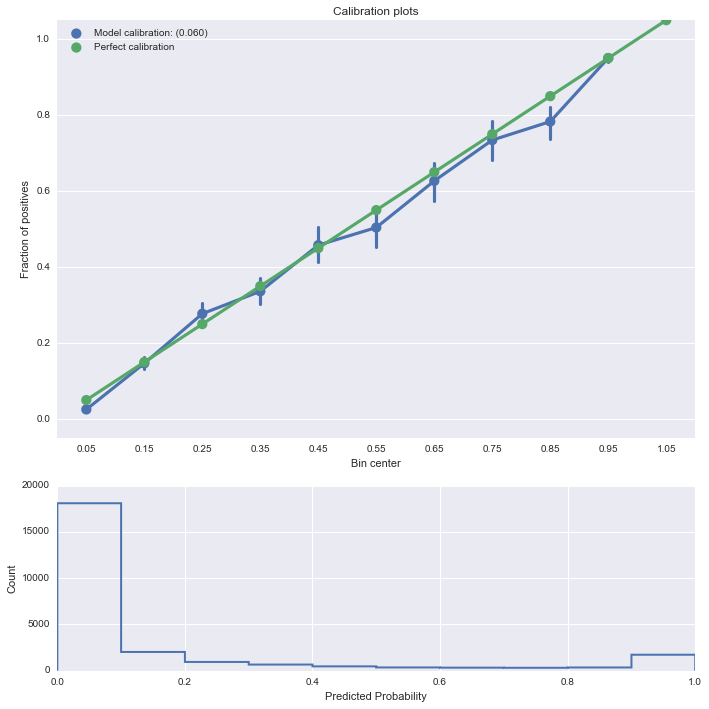

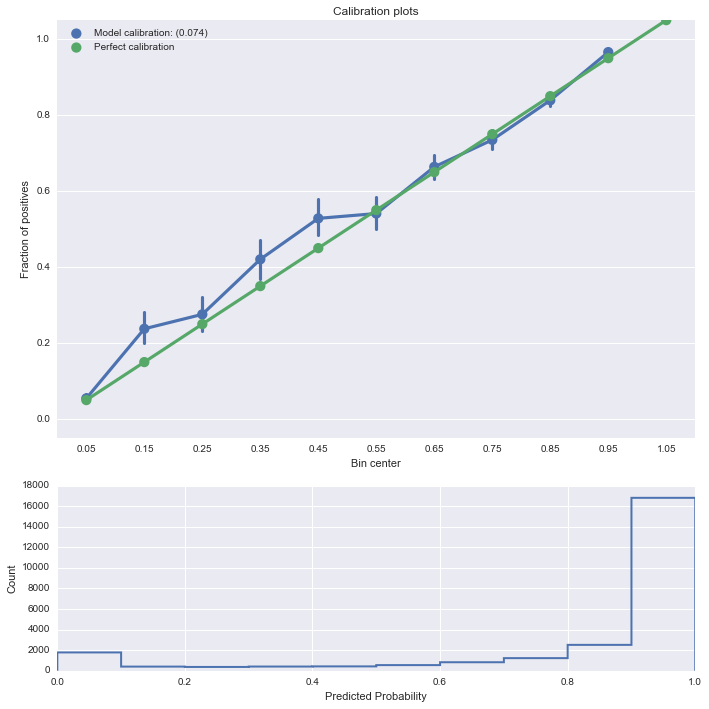

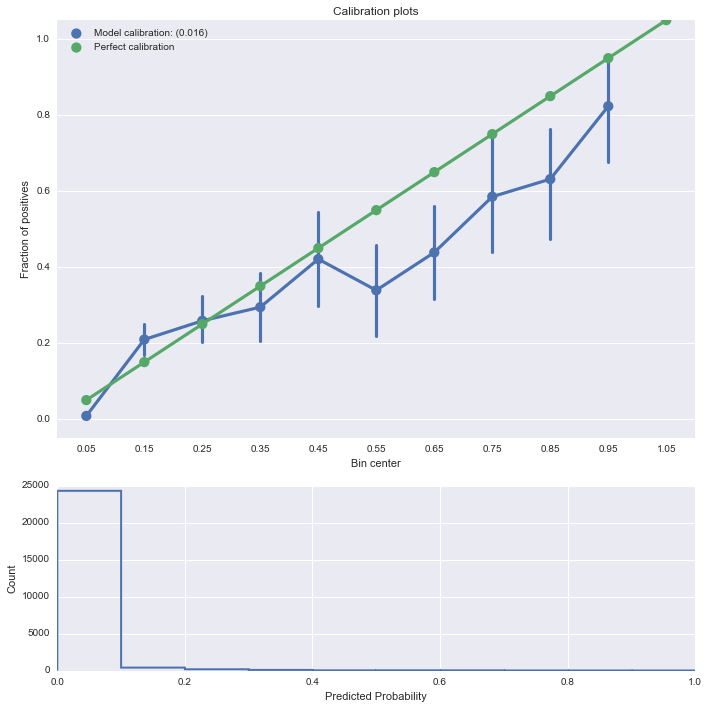

time: 55.5 s


In [16]:
y_test_oh = one_hot(y_test)
y_pred_ed = model.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()

### Error Analysis

In [17]:
for i in classes:
    print('\n\n\nCLASS: ', i)
    over, under = get_errors(X_test, y_test_oh[:, i], y_pred_ed[:, i])
    print('\n\nOVER\n')
    print_errors(over, n=10)
    print('\n\nUNDER\n')
    print_errors(under, n=10)




CLASS:  0


OVER

COMMENT:
 yadavs are kshatriyas wht the hell happend to previous stuff written in the wiki which well defined yadavs,know some anti yadavs have edited the stuff and added whole new crap,mentoning yadavs as shudras is funny shit....some fuckin moron must hv done this..
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
" Blocked by Freestylefrappe Yeah, that's right, blocked for saying ""IMHO WMC is a jerk."" Personal insult, huh? Sockpuppet? I'm fucking steamed, Freestylefrappe. And coming right after WMC's admin confirmation? If you're trying to punish me this is some of the most ridiculous bullshit gamesmanship I've ever seen.  "
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 Should this one be added? Roses are RedViolets are BlueI'll Fuck You with a Rake
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 Listen up. OK, listen up you god damn jerk. I'm really sick and tired of your shit. I'm sick of you stalking 

### Learning Curves!
How does adding more training data improve performance?

In [18]:
#ms, metrics = eval_adding_other_data(optimal_pipeline, None, None, X_test, y_test, X_train, y_train, roc_scorer)
#plot_adding_other_data(ms, metrics)

time: 716 µs


### Model Understanding

In [19]:
feature_names = np.array(model.named_steps['vect'].get_feature_names())
for i in classes:
    print('\n\nCLASS: ', i)
    
    try:
        coef = model.named_steps['clf'].coef_[i].ravel()
    except:
        coef = model.named_steps['clf'].coef_.ravel()
    most_pos_idx = np.argsort(coef)[-100:]
    most_pos = feature_names[most_pos_idx]
    print('STRONG POS: ')
    print(most_pos)
    most_neg_idx = np.argsort(coef)[:100]
    most_neg = feature_names[most_neg_idx]
    print('STRONG NEG: ')
    print(most_neg)



CLASS:  0
STRONG POS: 
['ose' ' dir' 'stop ' 'off' 'lie' 'f' ' pig' 'cum' 'edo' ' ret' 'ex ' ' ru'
 'eni' ' na' 'pen' ' hate' 'het' 'kil' 't u' 'you' ' fag' 'ole' ' off'
 ' u ' 'rse' 'bas' 're a ' ' a ' ' je' '. g' 'gina' 'cunt' '*' ' an'
 ' cock' ' cun' 'ron' 'hit' 'ast' 'ick' 'cock' 'bul' 'kill' ' fuck ' ' stu'
 'ude' ' coc' 'aci' 'shit ' ' die' 'id ' 'coc' ' cunt' 'fag' 'ck' 'nis'
 '""' 'sh' 'ss' ' bitc' ' bitch' ' hell' 'tar' 'azi' ' pen' ' gay' 'umb'
 '!' 'fuck ' 'bitc' 'utt' 'cis' ' dick' 'bitch' 'lia' ' shit' 'mn' 'ass'
 'up' 'id' 'stu' 'hole' 'gay' 'dam' 'dick' ' suck' ' id' ' fuck' 'suck'
 ' fuc' 'sex' 'rap' ' ass' 'pi' 'oro' 'shit' 'fuck' 'dio' 'fuc' 'idi']
STRONG NEG: 
['. ' 'tud' 'ello' ' "' 'thank' 'hi ' 'hank' 'ssu' 'uff' 'sum' ')' 'ura'
 ' )' 'log' 'uf' 'wish' 'ping' 'nic' ' but ' 'v' 'but ' 'tag' 'ook' ' ide'
 'put' 'pol' ' lot' 'llo' ' up' 'work' 'idea' ' idea' 'lot ' ' tag' ' lin'
 'lp' 'met' 'did' ' pic' 'done' 'roc' ' thank' 'pas' 'pic' ' es' 'anks'
 ' ni' 'ful' '

### Final Model

In [21]:
X, y = assemble_data(data, xtype, ytype)
final_model = optimal_pipeline.fit(X, y)
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/aggression_ngram.pkl',
 '../../models/aggression_ngram.pkl_01.npy',
 '../../models/aggression_ngram.pkl_02.npy',
 '../../models/aggression_ngram.pkl_03.npy',
 '../../models/aggression_ngram.pkl_04.npy',
 '../../models/aggression_ngram.pkl_05.npy',
 '../../models/aggression_ngram.pkl_06.npy']

time: 6min 55s
